# Evaluation and plotting for different experiments

- Write throughput (fio vs dd, isilon vs netapp)
- Containerized fio vs non-containerized fio

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as st

In [2]:
def load_data(filename, metric):
    data = load_file(filename)
    return extract_results(data, metric)

def load_file(filename):
    file = Path(filename)
    assert file.is_file()
    return json.loads(file.read_text())

def extract_results(data, metric, x_labels=None):
    x_labels = x_labels if x_labels else list(data["results"].keys())
    pd_data = []
    for label in x_labels:
        results = data["results"][label]
        values = [r[metric] for r in results]
        mean = np.mean(values)
        conf = confidence_interval(values)
        pd_data.append([mean, conf])


    df = pd.DataFrame(data=pd_data, index=x_labels, columns=["mean", "conf"])
    return df

def confidence_interval(values):
    confidence = 0.95
    dof = len(values)-1
    m = np.mean(values)
    sem = st.sem(values)
    interval = st.t.interval(alpha=confidence, df=dof, loc=m, scale=sem)
    if np.isnan(interval[0]) or np.isnan(interval[1]):
        return m * 10**-6
    return (interval[1]-interval[0])/2
    
def plot(filename, metric="write_bw_mean_in_mb"):
    data = load_file(filename)
    df = extract_results(data, metric=metric)
    print(df)
    ax = df["mean"].plot(kind='bar', rot=0, xlabel='Date', ylabel='Value', title='My Plot', figsize=(6, 4), yerr=df["conf"])
    plt.show()

## Experiment: Write throughput

- fio vs dd
- netapp vs isilon

                     mean      conf
fio+isilon 1   101.268498  0.177372
           2    99.807091  0.455288
           4    99.719745  0.339521
           8    98.950867  1.495982
           16   97.427137  0.052078
dd+isilon  1   111.200000  7.154399
           2   105.600000  1.415715
           4   103.000000  2.150625
           8   102.600000  0.680087
           16  102.000000  0.000102
fio+netapp 1   101.529620  0.286664
           2    99.178172  0.159219
           4    98.293395  0.081730
           8    97.802930  0.126442
           16   97.352155  0.200134
dd+netapp  1   112.800000  4.247144
           2   104.000000  2.322941
           4   103.600000  1.110578
           8   103.000000  0.000103
           16  101.800000  0.555289


/home/stefan/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stefan/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/stefan/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stefan/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


<IPython.core.display.Javascript object>


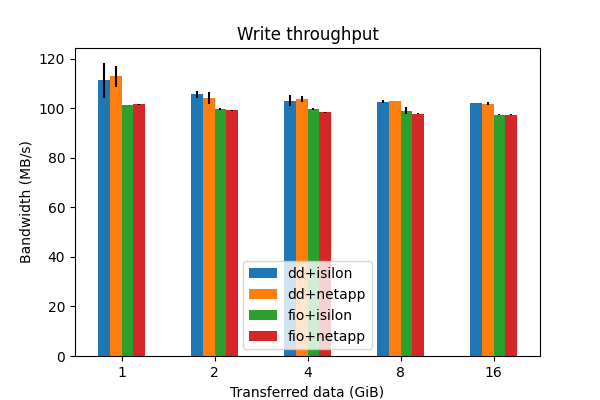

In [8]:
%matplotlib notebook
## Params
result_file_prefix = "2022-04-11T14:37:08_throughput_write_"

## Plot code
pre = result_file_prefix
df = pd.concat({
    "fio+isilon": load_data(f"../results/{pre}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon": load_data(f"../results/{pre}dd_isilon.json", "bw_in_mb"),
    "fio+netapp": load_data(f"../results/{pre}fio_netapp.json", "write_bw_mean_in_mb"),
    "dd+netapp": load_data(f"../results/{pre}dd_netapp.json", "bw_in_mb"),
})
df.rename(index={"1": "1G", "2": "2G", "4": "4G", "8": "8G", "16": "16G"}, inplace=True)
df.rename(index={"1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16}, inplace=True)
print(df)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MB/s)',
    title='Write throughput',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()


## Experiment: Containerized vs non-containerized

                        mean      conf
containerized      98.161797  0.185834
non-containerized  97.956398  0.046293


<IPython.core.display.Javascript object>


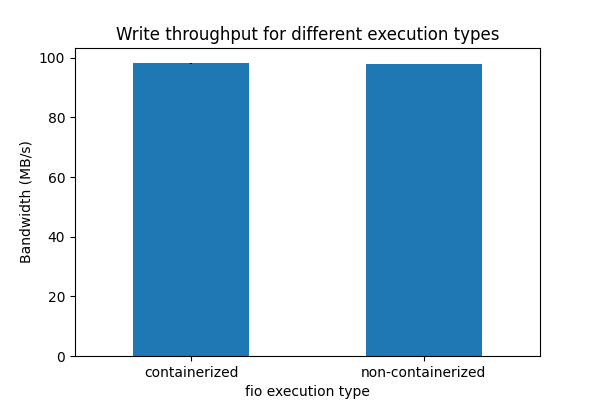

In [9]:
%matplotlib notebook
## Params
result_file_prefix = "2022-04-12T06:01:41_throughput_fio_"

## Plot code
pre = result_file_prefix
df = pd.concat([
    load_data(f"../results/{pre}containerized.json", "write_bw_mean_in_mb").rename(index={"irods_server__mnt_isilon": "containerized"}),
    load_data(f"../results/{pre}non_containerized.json", "write_bw_mean_in_mb").rename(index={"irods_server__mnt_isilon": "non-containerized"}),
])
print(df)

ax = df["mean"].plot(
    kind='bar', rot=0,
    xlabel='fio execution type',
    ylabel='Bandwidth (MB/s)',
    title='Write throughput for different execution types',
    figsize=(6, 4),
    yerr=df["conf"]
)
plt.show()

## Experiment: Compare isilon vs. netapp vs. fuse vs. davrods

In [20]:
## Params
result_file_prefix = "2022-04-18T15:21:17_benchmark"
result_file_prefix = "2022-04-19T08:01:46_benchmark"

## Plot code
data_isilon = load_file(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_file(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_file(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")
data_irods_davrods = load_file(f"../results/{result_file_prefix}_irods_davrods_on_isilon.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_mb"),
    ("throughput_read", "read_bw_mean_in_mb"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat([
        extract_results(data_isilon, metric, [label]),
        extract_results(data_netapp, metric, [label]),
        extract_results(data_irods_fuse, metric, [label]),
        extract_results(data_irods_davrods, metric, [label]),
    ])
    print(df)




                        mean      conf
throughput_write  105.004878  0.000105
throughput_write  104.390244  0.000104
throughput_write  120.678109  0.000121
throughput_write  395.850000  0.000396


/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: inva

KeyError: 'throughput_read'

In [ ]:
## Params
result_file_prefix = "2022-04-18T15:21:17_benchmark"

## Plot code
data_isilon = load_file(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_file(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_file(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_mb"),
    ("throughput_read", "read_bw_mean_in_mb"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat([
        extract_results(data_isilon, metric, [label]),
        extract_results(data_netapp, metric, [label]),
        extract_results(data_irods_fuse, metric, [label]),
    ])
    print(df)

